#### Imports

In [14]:
from Databases import MindBrainBody
from Databases import DepressionRest
from Databases import MODMA128

import mne
import mne_features
import pickle
import auxScripts as auxs
import numpy as np
import pandas as pd
from Databases import MindBrainBody
import matplotlib.pyplot as plt
import pickle
%matplotlib notebook

#### Directory and global Definitions

In [49]:
randomSeed=42 #fixed seed for reproducible results

dbDir = ''  #Change these according to your project location
outdir = '' #Change these according to your project location

channelsOfInterest=['Fz','Pz','Cz','Oz']
channelsOfInterestUppercase=[x.upper() for x in channelsOfInterest] #MODMA and DR use uppercased channel names
eventDurations = [60,40,20,6,4,2]

minFreq =0.1
maxFreq = 80
correction = 'zscore'
slide_size = 2 #apply a 2 seconds slide between each consecutive epoch

srate = 250 #MODMA has the lowest sampling rate of all 3 databases
n_fft=srate*1 #1 second FOR FFT
n_per_seg=n_fft #1 second FOR FFT
n_overlap=srate*0.5 #50% overlap on the sliding window FOR FFT
freq_bands=[minFreq, 4., 8., 13., 30., 80.]

DR_new_EC_code = 1 #code used in mne.Annotations to handle events and extract epochs; since DR has 3 different codes for the 1 minute task, we will group all of them into a single code

combinedFeatures = []
for a in channelsOfInterestUppercase:
    for b in eventDurations:
        for c in ['delta','theta','alpha','beta','gamma','sampleEntropy']:
            combinedFeatures.append((a,b,c))



#### DB Loading

In [3]:
mbb = MindBrainBody(dbDir+"MindBrainBody/AllSubjects/",'SubjectInfo')
print(mbb.to_string())

MIND-BRAIN-BODY DATASET
10-10 EEG system
Subjects:		204
Tasks:			['EO', 'EC']
Sampling Rate:		2500Hz
Bandpass:		0.016~1000
Channels:		['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'VEOG', 'CP5', 'CP1', 'CP2', 'CP6', 'AFz', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT7', 'FC3', 'FC4', 'FT8', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
EOG channels:		['VEOG']


Additional Info: All healthy subjects, plenty of data available, see files


In [4]:
dr = DepressionRest(dbDir+"DepressionRest/",'SubjectInfo.xlsx')
print(dr.to_string())

DEPRESSION-REST DATASET
10-10 EEG system
Subjects:		119
Tasks:			['EO500ms', 'EC500ms', 'EO2000ms', 'EC2000ms', 'EOMinute', 'ECMinute']
Sampling Rate:		500Hz
Bandpass:		0~250
Channels:		['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'HEOG', 'VEOG']
EOG channels:		['HEOG', 'VEOG']


Additional Info:
Available Subject information:
HamD ('Only done for those who did SCID'), Sex, age, BDI, BDI_Anh, BDI_Mel, TAI, also MDD_Note (containing some comorbidities or additional info about the subject

Subject Diagnosis
noSCID_Diagnosis (all CLT and some depressed):	90
noSCID_CriteriaMet:				9
MDD:						11
Past MDD:					12

Using BDI:(

In [5]:
modma = MODMA128(dbDir+"MODMA/Resting/EEG_128channels_resting_lanzhou_2015/Preprocessed/",'subjectsInfoWOLegend.xlsx')
print(modma.to_string())

MODMA DATASET (Only Eyes-Closed)
10-10 EEG system
Subjects:		53
Tasks:			['1 Minute(s)', '2 Minute(s)']
Sampling Rate:		250Hz
Bandpass:		0.1~80
Channels:		['F10', 'AF8', 'AF4', 'F2', 'E5', 'FCZ', 'E7', 'E8', 'FP2', 'E10', 'FZ', 'E12', 'FC1', 'FPZr', 'FPZ', 'AFZ', 'E17', 'E18', 'F1', 'E20', 'FPZl', 'FP1', 'AF3', 'F3', 'E25', 'AF7', 'F5', 'FC5', 'FC3', 'C1', 'E31', 'F9', 'F7', 'FT7', 'E35', 'C3', 'CP1', 'E38', 'FT8', 'E40', 'C5', 'CP3', 'E43', 'T9', 'T7', 'TP7', 'CP5', 'E48', 'E49', 'E50', 'P5', 'P3', 'E53', 'E54', 'CPZ', 'E56', 'TP9', 'P7', 'E59', 'P1', 'E61', 'PZ', 'E63', 'P9', 'PO7', 'E66', 'PO3', 'E68', 'E69', 'O1', 'E71', 'POZ', 'E73', 'E74', 'OZ', 'E76', 'PO4', 'E78', 'E79', 'E80', 'E81', 'E82', 'O2', 'E84', 'P2', 'E86', 'CP2', 'E88', 'E89', 'PO8', 'E91', 'P4', 'CP4', 'E94', 'P10', 'P8', 'P6', 'CP6', 'E99', 'E100', 'E101', 'TP8', 'C6', 'C4', 'C2', 'E106', 'E107', 'T8', 'E109', 'E110', 'FC4', 'FC2', 'E113', 'T10', 'E115', 'FT9', 'FC6', 'E118', 'E119', 'E120', 'FT10', 'F8', 'F6', 'F4

# EEGData structure
To handle each subject's epoch

In [16]:
class EEGData(object):
    
    #dataset -> Dataset object, such as mbb used in this work
    #subjectID -> subjectID used for reading the EEG
    #notch_filter (bool) -> if a notch filiter must be applied (Dataset handles it)
    #highpass, lowpass -> for bandpassing filters
    #correction -> eeg correction to be used in each epoch, defaults to 'zscore'
    #decim (int) -> value used for decimation, defaults to 1
    def __init__(self, dataset, subjectID, event_keys, notch_filter=True, highpass=None, lowpass=None, correction='zscore', decim=1):
        #preprocessing for each epoch
        self.notch_filter = notch_filter
        self.highpass= highpass
        self.lowpass=lowpass
        self.correction = correction
        self.decim = decim
        
        #dataset and subject info
        self.dataset = dataset
        self.subjectID = subjectID
        self.fullEEG = self.readEEG() #it will be generated by self.readEEG()
        self.event_keys = event_keys
        
        #Events and Epochs
        self.eventsAll = self.extractEvents(duration='all') #Holds eventAnnotations for all event_keys, whithout filtering for duration
        self.eventsPool = dict() #maps (duration (in seconds),code) -> eventAnnotations;
        self.epochs = dict() #dict generated and updated by self.extractEpochs(); it maps (code, duration) -> mne.Epochs
        self.blockInfo = dict() #dict generated and updated by self.extractEvents(), it holds the first and last (exclusive) epoch of each block
    
        
    #reads the EEG bandpasses and applies a notch filter, other preprocessing will be made at self.epochExtraction()
    #Notice that there is no sanity check, the user must choose a correct lowpassing prior to decimation
    def readEEG(self):
        eeg = self.dataset.read(self.subjectID, notch=self.notch_filter)
        if self.highpass != self.dataset.highpass and self.lowpass != self.dataset.lowpass:
            eeg.filter(self.highpass, self.lowpass)
        elif (self.highpass == self.dataset.highpass) and (self.lowpass is not None):  # avoids reapplying a highpass filter
            eeg.filter(None, self.lowpass)
        elif (self.lowpass == self.dataset.lowpass) and (self.highpass is not None):
            eeg.filter(self.highpass, None)  # avoids reapplying a lowpass filter
        
        return eeg
        
    #extractEvents() -> use anotations on the dataset to extract all epochs of interest, to be used after
    #event_keys (dict) -> dictionary associating the name of the anotation to its code, absent values will be discarded
    #limit (float) -> time (in seconds), of the last epoch of each block, e.g. 2.0s for EC in MBB (default)
    #blockSize -> ammount of epochs for each block, e.g. 30 for EC in MBB;
    #blockQty (int) -> ammount of blocks, e.g. 8 for EC in MBB (default)
    #task -> code of the task, e.g. 'EC' for Eyes Closed in MBB; leave None for duration='all'
    #code -> direct code of the task, e.g. 31 for ECMinute in DR; use only if task=None, unused in duration='all'
    #task_rename -> uses a new name for a task when saving the events
    #code_rename -> if task_renamme is True, will use a single code for the task in the event annotations
    #force_window -> forces the sliding window inside a single epoch; useful for DR and MODMA, useless for MBB (as it already has epochs annotated each 2 seconds)
    #slide_size -> size (in seconds) of the shift for the sliding window
    def extractEvents(self, limit=2.0, blockSize=30, blockQty=8, task=None, code=None, task_rename=None, code_rename=1, force_window=False, slide_size=2, duration='all'):
        import auxScripts as auxs
        import pandas as pd
        import numpy as np
        
        if duration=='all':
            events = auxs.annotToEvent(self.fullEEG, self.event_keys)
            eventspd = pd.DataFrame(events, columns=['onset(samples)','duration','code']) #samples at the original sampling rate
            eventspd.drop(eventspd[eventspd['code']==999999].index, axis='index', inplace=True) #dropping annotations for stimulus different from the one of interest
            self.eventsAll = eventspd.to_numpy() #mantaining original structure
            return self.eventsAll.copy()
        else:
            if self.eventsAll is None: #sanity check to avoid bugs, should be handled by the constructor
                self.extractEvents(duration='all')
            
            if code is None:
                cod = self.dataset.codes[task]
            else:
                cod = code
            
            events = self.eventsAll.copy()
            eventspd = pd.DataFrame(events, columns=['onset(samples)','duration','code']) #samples at the original sampling rate
            eventspd.drop(eventspd[eventspd['code']!=cod].index, axis='index', inplace=True) #dropping annotations for stimulus different from the one of interest
            eventsOfInterest = eventspd.to_numpy() #mantaining original structure
            
            filteredEvents=[]
            blocks = []
            #aserting there are at least one valid event
            if len(eventsOfInterest) == 0:
                if code is not None:
                    self.eventsPool[code,duration] = np.array([])
                else:
                    self.eventsPool[task,duration] = np.array([])
                return filteredEvents
            
            if force_window: #DR and MODMA, have only single 1 minute epochs, the sliding window must be done inside it
                for firstTimeEpoch, d, c in eventsOfInterest:
                    i=0
                    while(True):
                        if task_rename is not None:
                            c = code_rename
                        slide = slide_size*i*self.dataset.srate
                        newstart = firstTimeEpoch + slide
                        timelim = firstTimeEpoch + limit*self.dataset.srate
                        if newstart + self.dataset.srate*duration <= timelim:
                            filteredEvents.append([newstart,d,c])
                        else:
                            break
                        i=i+1                
            else: #MBB already has epochs spaced at 2 seconds each
                for i in range(0,blockQty):
                    lastEpochStart = eventsOfInterest[((i+1)*blockSize)-1][0] #selects the event at the end of this block and holds the timestamp start (in samples)
                    timelim = int(np.floor(lastEpochStart + self.dataset.srate*limit)) #adds limit seconds after the lastEpochStart, notice that timelim is in samples

                    for x in eventsOfInterest[i*blockSize:(i+1)*blockSize]:
                        #      add event if the start+the duration (in samples) does not pass the limit, for each epoch in this block
                        if x[0]+self.dataset.srate*duration <= timelim:
                            filteredEvents.append(x)        

            filteredEvents = np.array(filteredEvents)
            
            if task_rename is None:
                eventPoolInitialized = self.eventsPool.get((task,duration), None) is not None
                if eventPoolInitialized: #adds new events to the pool; usefull for DR, as it needs many calls to this script
                    self.eventsPool[task,duration] = np.concatenate([self.eventsPool[task,duration], filteredEvents.copy()])
                else:
                    self.eventsPool[task,duration] = filteredEvents.copy()
            else:
                eventPoolInitialized = self.eventsPool.get((task_rename,duration), None) is not None
                if eventPoolInitialized:
                    self.eventsPool[task_rename,duration] = np.concatenate([self.eventsPool[task_rename,duration], filteredEvents.copy()])
                else:
                    self.eventsPool[task_rename,duration] = filteredEvents.copy()
            return filteredEvents
    
    #extractEpochs() -> extracts eeg epochs using the anotations provided by extractEvents, it assumes the amount of epochs of that type is equal to all subjects
    #      IMPORTANT: it returns a dictionary which maps: (code, duration) -> mne.Epochs
    #                   it has no information about the preprocessing that was done, save the files accordingly
    #                   For applications that aim not to save files, it will change the self.epochs attribute, notice that it will be updated each time this method is called (be aware of conflicting keys)
    #task -> code of the anotation, e.g. 'EC' for Eyes closed in MBB dataset
    #duration -> duration of epochs, in seconds
    #task_code -> task code is passed directly (e.g. for DR, which has a special code for all 3 blocks); if None, will find the code using the task name
    #save (bool) -> if True will add the epochs to self.eventsPool, otherwise only returns it (default); we do not save it in the structure as the files were getting too big (around 3.7Gb) for this experiment
    def extractEpochs(self, task, duration, task_code=None, save=False):
        import mne
        if self.eventsPool.get((task,duration),None) is None:
            raise Exception("Must call extractEvents() to filter the valid starting points for each epoch")
        
        events = self.eventsPool[task,duration]
        if task_code is None:
            task_code = self.dataset.codes[task]
        
        epochs = mne.Epochs(self.fullEEG, events, task_code, tmin=0, tmax=duration, baseline=None,
                            reject_by_annotation=True, preload=True, on_missing='ignore', decim=self.decim)
        
        if save:
            self.epochs[task,duration] = epochs.copy()
            
        return epochs
    
    

# Code

### Auxiliary Codes (preprocessing and subject removal)

#### For MBB
Verifies if the annotation 'Stimulus 1' immediatly precedes the first eyes closed annotation; this verification is important to avoid data extraction corruption when a new annotation (e.g. Bad_Blink) occurs

In [ ]:
event_keys = {'Stimulus/S200': mbb.codes["EO"], 'Stimulus/S210': mbb.codes["EC"],'Stimulus/S  1': mbb.codes["first_stim"]}
problemaOrdem=[] #Anota aqueles que não começam com 'Stimulus/S  1' no primeiro bloco
problemaCount=[] #Anota aqueles que não possuem 240 épocas Stimulus/S210
semEC=[] #sem EC, essa verificação é importante, pois alguns indivíduos, e.g. sub-032385, não possuem S210, apenas S208, que não foi encontrado na documentação
semFS=[] #sem first Stim, checando por garantia
for subID in mbb.subjectList:
    flagErro=False #armazena se houve erro de encontrar algum dos Stimulus
    eeg = mbb.read(subID, notch=True)
    
    eventsTest = auxs.annotToEvent(eeg, event_keys)
    eventsTestdf = pd.DataFrame(eventsTest, columns=['onset(samples)','duration','code'])
    eventsTestdf.drop(eventsTestdf[eventsTestdf['code']==999999].index, axis='index', inplace=True) #dropping annotations for stimulus different from the one of interest
    eventsTestdf.index = np.arange(0,len(eventsTestdf),1) #reindexando
    if len(eventsTestdf[eventsTestdf['code']==mbb.codes['EC']]) == 0: 
        semEC.append(subID)
        flagErro=True
    if len(eventsTestdf[eventsTestdf['code']==mbb.codes['first_stim']]) == 0:
        semFS.append(subID)
        flagErro=True
    #só verifica os problemas de ordem se estímulo EC stiver presente
    if not flagErro:
        if len(eventsTestdf[eventsTestdf['code']==mbb.codes["EC"]]) != 240:
            problemaCount.append((subID,len(eventsTestdf[eventsTestdf['code']==mbb.codes["EC"]])))
        if eventsTestdf[eventsTestdf['code']==mbb.codes["EC"]].index[0] == 0: #Caso o EEG comece com um EC e não com um 'Stimulus/S  1'
            problemaOrdem.append(subID)
        else:
            firstimEsperadoEm = eventsTestdf[eventsTestdf['code']==mbb.codes["EC"]].index[0] -1
            if not eventsTestdf.loc[firstimEsperadoEm]['code'] == mbb.codes['first_stim']: #Um Stimulus 1 sempre antecede o primeiro 
                problemaOrdem.append(subID)

    

In [ ]:
print(semEC)
print(problemaOrdem)
print(problemaCount)
print(semFS)
#Removendo indivíduos que tenham problema de ordem, contagem ou ausência de EC; manteremos o sem 'Stimulus/S  1' inicial, pois é contornável e eliminaria muitas amostras caso contrário
sublist = mbb.subjectList.copy()
[sublist.remove(x) for x, _ in problemaCount if x in sublist]
#sublist.remove(x) for x in problemaOrdem if x in sublist] #após chegagem manual não é necessario remover esse caso
[sublist.remove(x) for x in semEC if x in sublist]
print(len(sublist))
#print(sublist)
import pickle
with open(outdir+'validSubjectListMBB.array','wb') as outfile:
    pickle.dump(sublist,outfile)

#### For DR and MODMA, no subject filtering was needed

### Extracting each subject valid epochs

#### for MBB

In [ ]:
t='EC' #Eyes closed
decim = 10 # 2500Hz / 250Hz  = decimation of 10 for MBB, it will be lowpassed at 250Hz before decimation to avoid aliasing
event_keys = {'Stimulus/S200': mbb.codes["EO"],'Stimulus/S210': mbb.codes["EC"],'Stimulus/S  1': mbb.codes["first_stim"]}
limit = 2.0
#Lendo lista de indivíduos válidos
with open(outdir+'validSubjectListMBB.array','rb') as infile:
    subjectList = pickle.load(infile)
    
for subID in subjectList:
    subjectData = EEGData(mbb, subID, event_keys,  notch_filter=True, highpass=minFreq, lowpass=maxFreq, correction=correction, decim=decim)

    for duration in eventDurations:
        subjectData.extractEvents(limit=limit, blockSize=30, blockQty=8, task=t, duration=duration)
        #subjectData.extractEpochs(task=t, duration=duration, save=True) #it was generating way too big files (around 3.7Gb); epoch extraction will be made as we extract the features
    
    with open(outdir+'eegData/MBB/'+str(subID)+'.eegdata','wb') as outfile:
        pickle.dump(subjectData, outfile)


#### for DR

In [ ]:
t='EC' #Eyes closed
decim = 2 # 500Hz / 250Hz  = decimation each 2
limit = dr.timeOfTask['ECMinute']

#Lendo lista de indivíduos válidos
event_keys = {} #DR already has numbered events, so there is no need to pass a mapping
for subID in dr.subjectList:
    subjectData = EEGData(dr, subID, event_keys=event_keys, notch_filter=True, highpass=minFreq, lowpass=maxFreq, correction=correction, decim=decim)

    for duration in eventDurations:
        subjectData.extractEvents(limit=limit, blockSize=1, task=t, code=31, task_rename='EC', code_rename=DR_new_EC_code, force_window=True, slide_size=slide_size, duration=duration)
        subjectData.extractEvents(limit=limit, blockSize=1, task=t, code=33, task_rename='EC', code_rename=DR_new_EC_code, force_window=True, slide_size=slide_size, duration=duration)
        subjectData.extractEvents(limit=limit, blockSize=1, task=t, code=35, task_rename='EC', code_rename=DR_new_EC_code, force_window=True, slide_size=slide_size, duration=duration)
        
    with open(outdir+'eegData/DR/'+str(subID)+'.eegdata','wb') as outfile:
        pickle.dump(subjectData, outfile)

#### for MODMA

In [ ]:
t='1 Minute(s)' #Eyes closed
task_rename = 'EC' ## will save the epochs using this as the task; this way it will be the same for all datasets
decim = 1 # 250Hz / 250Hz  = no decimation
limit = modma.timeOfTask[t]
#Lendo lista de indivíduos válidos
#with open(outdir+'validSubjectListMBB.array','rb') as infile:
#    subjectList = pickle.load(infile)
event_keys = {'1 Minute(s)': 1}
for subID in modma.subjectList:
    subjectData = EEGData(modma, subID, event_keys=event_keys, notch_filter=True, highpass=minFreq, lowpass=maxFreq, correction=correction, decim=decim)

    for duration in eventDurations:
        subjectData.extractEvents(limit=limit, task=t, force_window=True, task_rename=task_rename, slide_size=slide_size, duration=duration)
        
    with open(outdir+'eegData/MODMA/'+str(subID)+'.eegdata','wb') as outfile:
        pickle.dump(subjectData, outfile)

### Feature Extraction


In [17]:
#It Normalizes the results obtained from mne_features.univariate.compute_pow_freq_bands, the built-in normalization was returning summations different than 1 (above expected precision errors)
def normalizeFreqBands(results):
    df = pd.DataFrame(results.T)
    df = df/df.sum(axis=0)
    aux = df.to_numpy()
    resultsNorm = aux.T
    return np.squeeze(resultsNorm)


#### For MBB

In [10]:
task = 'EC'

with open(outdir+'validSubjectListMBB.array','rb') as infile:
    subjectList = pickle.load(infile)
    
allSubjFeatures = dict() #holds lists with all subject info for that feature
for subID in subjectList:
    with open(outdir+'eegData/MBB/'+str(subID)+'.eegdata','rb') as infile:
        subjectData = pickle.load(infile)
    
    extractedFeatures = dict() #keys are triples (channel, duration, feature);
                                #being feature in {'theta','delta','alpha','beta','gamma','sampleEntropy'}
                                #channel will be in uppercase for all data
    
    for duration in eventDurations:
        desiredEpochs = subjectData.extractEpochs(task, duration, save=False)
        
        for ch in channelsOfInterest:
            for epochID in range(0,len(desiredEpochs)):
                eeg = desiredEpochs[epochID].get_data(picks=ch)
                eeg = np.array([np.squeeze(eeg)]) #removes one redundant dimension with only one tuple

                
                ####
                # Extracting Band Power Information
                ####
                #default unimportant parameters were ommited
                allBands = mne_features.univariate.compute_pow_freq_bands(sfreq=srate,
                                                           data=eeg,
                                                           freq_bands=freq_bands,
                                                           normalize=False,
                                                           log=False,
                                                           psd_method='welch',
                                                           psd_params={'welch_n_fft':n_fft, 'welch_n_per_seg':n_per_seg, 'welch_n_overlap': n_overlap})


                relativeBands = normalizeFreqBands(allBands)
                
                for band, band_idx in zip(['delta','theta','alpha','beta','gamma'],[0,1,2,3,4]):
                    #updating single subject info
                    newInfoAux = extractedFeatures.get((ch.upper(), duration, band), list())
                    newInfoAux.append(relativeBands[band_idx])
                    extractedFeatures[(ch.upper(), duration, band)] = newInfoAux

                    #updating all subject info
                    newInfoAux = allSubjFeatures.get((ch.upper(), duration, band), list())
                    newInfoAux.append(relativeBands[band_idx])
                    allSubjFeatures[(ch.upper(), duration, band)] = newInfoAux
                
                
                ####
                # Extracting Sample Entropy Information
                ####
                #default unimportant parameters were ommited
                SE = mne_features.univariate.compute_samp_entropy(data=eeg)
                
                newInfoAux = extractedFeatures.get((ch.upper(), duration, 'sampleEntropy'),list())
                newInfoAux.append(SE[0])
                extractedFeatures[(ch.upper(), duration, 'sampleEntropy')] = newInfoAux
                
                newInfoAux = allSubjFeatures.get((ch.upper(), duration, 'sampleEntropy'), list())
                newInfoAux.append(SE[0])
                allSubjFeatures[(ch.upper(), duration, 'sampleEntropy')] = newInfoAux

                
    ######
    ## Saving Data
    ######
    with open(outdir+'features/MBB/'+str(subID)+'.dict','wb') as outfile:
        pickle.dump(extractedFeatures, outfile)

            

Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline correction applied
0 proj

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
231 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
223 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 223 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 150001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
88 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 88 events and 100001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 50001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
224 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 224 events and 15001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
232 matching events found
No baseline corr

0 bad epochs dropped


In [18]:
with open(outdir+'validSubjectListMBB.array','rb') as infile:
    subjectList = pickle.load(infile)

allSubj = []
for subj in subjectList:
    with open(outdir+'features/MBB/'+str(subj)+'.dict','rb') as infile:
        allSubj.append(pickle.load(infile))
        
MBBallSubjFeatures = dict()
for f in combinedFeatures:
    MBBallSubjFeatures[f] = []
    for subjInfo in allSubj:
        MBBallSubjFeatures[f].append(subjInfo[f])
        
with open(outdir+'features/MBB/AllSubjects.dict','wb') as outfile:
    pickle.dump(MBBallSubjFeatures, outfile)

#### For DR

In [8]:
task = 'EC'
    
allSubjFeatures = dict() #holds lists with all subject info for that feature
for subID in dr.subjectList:
    with open(outdir+'eegData/DR/'+str(subID)+'.eegdata','rb') as infile:
        subjectData = pickle.load(infile)
    
    extractedFeatures = dict() #keys are triples (channel, duration, feature);
                                #being feature in {'theta','delta','alpha','beta','gamma','sampleEntropy'}
                                #channel will be in uppercase for all data
    
    for duration in eventDurations:
        desiredEpochs = subjectData.extractEpochs(task, duration, task_code=DR_new_EC_code, save=False)
        
        for ch in channelsOfInterestUppercase:
            for epochID in range(0,len(desiredEpochs)):
                eeg = desiredEpochs[epochID].get_data(picks=ch)
                eeg = np.array([np.squeeze(eeg)]) #removes one redundant dimension with only one tuple

                
                ####
                # Extracting Band Power Information
                ####
                #default unimportant parameters were ommited
                allBands = mne_features.univariate.compute_pow_freq_bands(sfreq=srate,
                                                           data=eeg,
                                                           freq_bands=freq_bands,
                                                           normalize=False,
                                                           log=False,
                                                           psd_method='welch',
                                                           psd_params={'welch_n_fft':n_fft, 'welch_n_per_seg':n_per_seg, 'welch_n_overlap': n_overlap})


                relativeBands = normalizeFreqBands(allBands)
                
                for band, band_idx in zip(['delta','theta','alpha','beta','gamma'],[0,1,2,3,4]):
                    #updating single subject info
                    newInfoAux = extractedFeatures.get((ch.upper(), duration, band), list())
                    newInfoAux.append(relativeBands[band_idx])
                    extractedFeatures[(ch.upper(), duration, band)] = newInfoAux

                    #updating all subject info
                    newInfoAux = allSubjFeatures.get((ch.upper(), duration, band), list())
                    newInfoAux.append(relativeBands[band_idx])
                    allSubjFeatures[(ch.upper(), duration, band)] = newInfoAux
                
                
                ####
                # Extracting Sample Entropy Information
                ####
                #default unimportant parameters were ommited
                SE = mne_features.univariate.compute_samp_entropy(data=eeg)
                
                newInfoAux = extractedFeatures.get((ch.upper(), duration, 'sampleEntropy'),list())
                newInfoAux.append(SE[0])
                extractedFeatures[(ch.upper(), duration, 'sampleEntropy')] = newInfoAux
                
                newInfoAux = allSubjFeatures.get((ch.upper(), duration, 'sampleEntropy'), list())
                newInfoAux.append(SE[0])
                allSubjFeatures[(ch.upper(), duration, 'sampleEntropy')] = newInfoAux
    
                
    ######
    ## Saving Data
    ######
    with open(outdir+'features/DR/'+str(subID)+'.dict','wb') as outfile:
        pickle.dump(extractedFeatures, outfile)


Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection i

3 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using 

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw 

0 projection items activated
Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original

Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decima

0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction 

Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction applied
0 projection 

33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using

C:\Users\fernando\AppData\Local\Temp\ipykernel_4684\3043459498.py:146: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(self.fullEEG, events, task_code, tmin=0, tmax=duration, baseline=None,


Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped


C:\Users\fernando\AppData\Local\Temp\ipykernel_4684\3043459498.py:146: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(self.fullEEG, events, task_code, tmin=0, tmax=duration, baseline=None,


Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped


C:\Users\fernando\AppData\Local\Temp\ipykernel_4684\3043459498.py:146: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(self.fullEEG, events, task_code, tmin=0, tmax=duration, baseline=None,


Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped


C:\Users\fernando\AppData\Local\Temp\ipykernel_4684\3043459498.py:146: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(self.fullEEG, events, task_code, tmin=0, tmax=duration, baseline=None,


Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped


C:\Users\fernando\AppData\Local\Temp\ipykernel_4684\3043459498.py:146: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(self.fullEEG, events, task_code, tmin=0, tmax=duration, baseline=None,


Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 1001 original time points (prior to decimation) ...
0 bad epochs dropped


C:\Users\fernando\AppData\Local\Temp\ipykernel_4684\3043459498.py:146: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(self.fullEEG, events, task_code, tmin=0, tmax=duration, baseline=None,


Not setting metadata
3 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection i

3 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using 

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw 

0 projection items activated
Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original

Using data from preloaded Raw for 3 events and 30001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decima

0 bad epochs dropped
Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction 

Not setting metadata
33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction applied
0 projection 

33 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using

No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw 

0 projection items activated
Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 1001 original

Using data from preloaded Raw for 33 events and 20001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 1001 original time points (prior to decima

0 bad epochs dropped
Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 1001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
3 matching events found
No baseline correction ap

Not setting metadata
63 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 63 events and 10001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
84 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 84 events and 3001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
87 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 87 events and 2001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
90 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 90 events and 1001 original time points (prior to decimation) ...
0 bad epochs dropped
Not setting metadata
3 matching events found
No baseline correction applied
0 projection it

In [ ]:
allSubj = []
for subj in dr.subjectList:
    with open(outdir+'features/DR/'+str(subj)+'.dict','rb') as infile:
        allSubj.append(pickle.load(infile))
        
DRallSubjFeatures = dict()
for f in combinedFeatures:
    DRallSubjFeatures[f] = []
    for subjInfo in allSubj:
        DRallSubjFeatures[f].append(subjInfo[f])
        
with open(outdir+'features/DR/AllSubjects.dict','wb') as outfile:
    pickle.dump(DRallSubjFeatures, outfile)

#### For MODMA

In [9]:
task = 'EC'
    
allSubjFeatures = dict() #holds lists with all subject info for that feature
for subID in modma.subjectList:
    with open(outdir+'eegData/MODMA/'+str(subID)+'.eegdata','rb') as infile:
        subjectData = pickle.load(infile)
    
    extractedFeatures = dict() #keys are triples (channel, duration, feature);
                                #being feature in {'theta','delta','alpha','beta','gamma','sampleEntropy'}
                                #channel will be in uppercase for all data
    
    for duration in eventDurations:
        desiredEpochs = subjectData.extractEpochs(task, duration, task_code=modma.codes['1 Minute(s)'], save=False)
        
        for ch in channelsOfInterestUppercase:
            for epochID in range(0,len(desiredEpochs)):
                eeg = desiredEpochs[epochID].get_data(picks=ch)
                eeg = np.array([np.squeeze(eeg)]) #removes one redundant dimension with only one tuple

                
                ####
                # Extracting Band Power Information
                ####
                #default unimportant parameters were ommited
                allBands = mne_features.univariate.compute_pow_freq_bands(sfreq=srate,
                                                           data=eeg,
                                                           freq_bands=freq_bands,
                                                           normalize=False,
                                                           log=False,
                                                           psd_method='welch',
                                                           psd_params={'welch_n_fft':n_fft, 'welch_n_per_seg':n_per_seg, 'welch_n_overlap': n_overlap})


                relativeBands = normalizeFreqBands(allBands)
                
                for band, band_idx in zip(['delta','theta','alpha','beta','gamma'],[0,1,2,3,4]):
                    #updating single subject info
                    newInfoAux = extractedFeatures.get((ch.upper(), duration, band), list())
                    newInfoAux.append(relativeBands[band_idx])
                    extractedFeatures[(ch.upper(), duration, band)] = newInfoAux

                    #updating all subject info
                    newInfoAux = allSubjFeatures.get((ch.upper(), duration, band), list())
                    newInfoAux.append(relativeBands[band_idx])
                    allSubjFeatures[(ch.upper(), duration, band)] = newInfoAux
                
                
                ####
                # Extracting Sample Entropy Information
                ####
                #default unimportant parameters were ommited
                SE = mne_features.univariate.compute_samp_entropy(data=eeg)
                
                newInfoAux = extractedFeatures.get((ch.upper(), duration, 'sampleEntropy'),list())
                newInfoAux.append(SE[0])
                extractedFeatures[(ch.upper(), duration, 'sampleEntropy')] = newInfoAux
                
                newInfoAux = allSubjFeatures.get((ch.upper(), duration, 'sampleEntropy'), list())
                newInfoAux.append(SE[0])
                allSubjFeatures[(ch.upper(), duration, 'sampleEntropy')] = newInfoAux
    
                
    ######
    ## Saving Data
    ######
    with open(outdir+'features/MODMA/'+str(subID)+'.dict','wb') as outfile:
        pickle.dump(extractedFeatures, outfile)
        

Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 15001 original time points ...
0 bad epochs dropped
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 55 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 105 events and 5001 original time points ...
0 bad epochs dropped
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 140 events and 1501 original time points ...
0 bad epochs dropped
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 1001 original time p

0 bad epochs dropped
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 15001 original time points ...
0 bad epochs dropped
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 55 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 105 events and 

0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 105 events and 5001 original time points ...
0 bad epochs dropped
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 140 events and 1501 original time points ...
0 bad epochs dropped
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 

0 bad epochs dropped
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 15001 original time points ...
0 bad epochs dropped
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 55 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 105 events and 5001 original time points ...
0 bad epochs dropped
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 140 events and 1501 original time points ...
0 bad epochs dropped
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and

0 bad epochs dropped
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 15001 original time points ...
0 bad epochs dropped
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 55 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 105 events and 

0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 105 events and 5001 original time points ...
0 bad epochs dropped
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 140 events and 1501 original time points ...
0 bad epochs dropped
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 

0 bad epochs dropped
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 15001 original time points ...
0 bad epochs dropped
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 55 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 105 events and 5001 original time points ...
0 bad epochs dropped
Not setting metadata
140 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 140 events and 1501 original time points ...
0 bad epochs dropped
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and

0 bad epochs dropped
Not setting metadata
145 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 145 events and 1001 original time points ...
0 bad epochs dropped
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 501 original time points ...
0 bad epochs dropped
Not setting metadata
5 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 5 events and 15001 original time points ...
0 bad epochs dropped
Not setting metadata
55 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 55 events and 10001 original time points ...
0 bad epochs dropped
Not setting metadata
105 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 105 events and 

In [ ]:
allSubj = []
for subj in modma.subjectList:
    with open(outdir+'features/MODMA/'+str(subj)+'.dict','rb') as infile:
        allSubj.append(pickle.load(infile))
        
MODMAallSubjFeatures = dict()
for f in combinedFeatures:
    MODMAallSubjFeatures[f] = []
    for subjInfo in allSubj:
        MODMAallSubjFeatures[f].append(subjInfo[f])
        
with open(outdir+'features/MODMA/AllSubjects.dict','wb') as outfile:
    pickle.dump(MODMAallSubjFeatures, outfile)

### Extracting Information
Extracting intra-subject and global information (specially, quartiles), and calculating each individual RMC and the mean RMC for each feature

In [22]:
## it handles the information contained in both bandInfo and sampleEntropyInfo, extracting means, stds, etc.
## it needs to be extended if another feature is added
## data (dict)-> features extracted for all subjects
## features (list) -> list of features added in the feature extraction step
## channelsOfInterest (list) -> list of channels used
## eventDurations (list) -> list of event durations used
## subjectList (list) -> used for reference
class InfoHelper(object):
    
    #the default exeperiment uses these bands with the following intervals: [0.1, 4., 8., 13., 30., 80.]
    def __init__(self, data, features = ['delta','theta','alpha','beta','gamma','sampleEntropy'],
                 channelsOfInterest=channelsOfInterestUppercase,
                 eventDurations = eventDurations, subjectList=None):
        
        self.data = data
        self.features = features
        self.channels = channelsOfInterest
        self.durations = eventDurations
        self.subjectList = subjectList
        
        self.featureKeys = self._combine(self.channels, self.durations, self.features) #combines to achieve the keys used in featureExtraction
        
        self.globalInfo = self.extractGlobalInfo() #featurekey -> pandas.Series, obtained by describe(), it has 'mean', 'std', 'min', '25%', '50%', '75%', 'max' and 'count'
        self.individualInfo = self.extractSubjInfo() #featurekey -> list of pandas.Series, as above
        
        self.RMC, self.meanRMC = self.extractRMC()
        
    
    def _combine(self, A,B,C):
        combined = []
        for a in A:
            for b in B:
                for c in C:
                    combined.append((a,b,c))
        return combined
    
    def extractGlobalInfo(self):
        import pandas as pd
        import numpy as np
        from tqdm import tqdm
        
        globalInfo = dict()
        for key in self.featureKeys:
            flat = []
            for subjData in self.data[key]:
                for data in subjData:
                    flat.append(data)
            globalInfo[key] = pd.Series(flat).describe()
        
        return globalInfo
    
    
    def extractSubjInfo(self):
        import pandas as pd
        from tqdm import tqdm
        
        individualInfo = dict()
        for key in tqdm(self.featureKeys):
            individualInfo[key] = []
            for subjData in self.data[key]:
                statInfo = pd.Series(subjData).describe()
                individualInfo[key].append(statInfo)
                
        return individualInfo
    
    def extractRMC(self):
        from tqdm import tqdm
        
        RMC = dict()
        for f in tqdm(self.featureKeys):
            subjRMC = []
            globalInterquartile = self.globalInfo[f]['75%'] - self.globalInfo[f]['25%']
            for subjInfo in self.individualInfo[f]:
                rmc = (subjInfo['75%'] - subjInfo['25%']) / (globalInterquartile)
                subjRMC.append(rmc)
                
            RMC[f] = subjRMC
        
        meanRMC = dict()
        for f in tqdm(self.featureKeys):
            meanRMC[f] = np.array(RMC[f]).mean()
        return RMC, meanRMC
        
    

In [72]:
with open(outdir+'validSubjectListMBB.array','rb') as infile:
    subjectList = pickle.load(infile)

with open(outdir+'features/MBB/AllSubjects.dict','rb') as infile:
    MBBallSubjFeatures = pickle.load(infile)
    
infoMBB = InfoHelper(MBBallSubjFeatures, subjectList = subjectList)

100%|█████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 71936.61it/s]


In [73]:
with open(outdir+'features/MBB/InfoData.dict','wb') as outfile:
    pickle.dump(infoMBB, outfile)

In [ ]:
with open(outdir+'features/DR/AllSubjects.dict','rb') as infile:
    DRallSubjFeatures = pickle.load(infile)
    
infoDR = InfoHelper(DRallSubjFeatures, subjectList=dr.subjectList)

In [ ]:
with open(outdir+'features/DR/InfoData.dict','wb') as outfile:
    pickle.dump(infoDR, outfile)

In [ ]:
with open(outdir+'features/MODMA/AllSubjects.dict','rb') as infile:
    MODMAallSubjFeatures = pickle.load(infile)
    
infoMODMA = InfoHelper(MODMAallSubjFeatures, subjectList=modma.subjectList)

In [ ]:
with open(outdir+'features/MODMA/InfoData.dict','wb') as outfile:
    pickle.dump(infoMODMA, outfile)

#### Plotting Data
The code below plots the global distribution, then animates plotting the distribution for each individual subject; moreover it plots a simulated average distribution (cosidering a normal distribution with the the average mean and variance of all subjects for that feature).

It shows 3 numbers: in blue the RMC for that subject; in green the RMC for the mean RMC of all subjects
It shows 3 distributions of feature values:  in blue are for each individual; in green an illustrative distribution with the avereag mean and std of all subjtects (notice that is not used to calculate the mean RMC); in red the global distribution, considering all epochs of all subjects

In [74]:
with open(outdir+'features/MODMA/InfoData.dict','rb') as infile:
    infoMODMA = pickle.load(infile)
    
with open(outdir+'features/DR/InfoData.dict','rb') as infile:
    infoDR = pickle.load(infile)

with open(outdir+'features/MBB/InfoData.dict','rb') as infile:
    infoMBB = pickle.load(infile)

In [76]:
def plot(ax, i, ch, duration, feature, info, ylim, plotRMC, global_color, average_color, subject_color):
    ax.clear()
    
    ax.set_ylim([0,ylim])
    
    subjectID = i
    #ax.text(0, ylim*0.85, subjectID, bbox=dict(facecolor='red', alpha=0.2)) #debug text
    
    #plotting global information (and calculating averages of std and mean)
    flatGlobalData = []
    avgMean = 0
    avgStd = 0
    for subj in info.data[(ch,duration,feature)]:
        for data in subj:
            flatGlobalData.append(data)
        avgMean = avgMean + np.array(subj).mean()
        avgStd = avgStd + np.array(subj).std()
    avgMean = avgMean/len(info.data[(ch,duration,feature)])
    avgStd = avgStd/len(info.data[(ch,duration,feature)])
    
    xmin = np.min(flatGlobalData)
    xmax = np.max(flatGlobalData)
    ax.set_xlim([xmin*1.1,xmax*1.1])
    graph = sns.kdeplot(data=flatGlobalData, color = global_color, ax=ax)
    
    
    #Plotting Estimated individual Distribution
    individualData = info.data[(ch,duration,feature)][subjectID]
    graph = sns.kdeplot(data=individualData, color = subject_color, ax=ax)
    if plotRMC:
        rmc = info.RMC[(ch,duration,feature)][subjectID]
        ax.text((xmax-xmin)/2, ylim*0.75, np.round(rmc,4), bbox=dict(facecolor=subject_color, alpha=0.2))
    
    #Plotting Average individual distribution
    x = np.linspace(xmin, xmax, 1000)
    
    #create normal distribution curve
    ax.plot(x, norm.pdf(x, avgMean, avgStd), color=average_color)
    
    #if plotRMC:
    #    q25,q75 = [avgMean-0.67448*avgStd,avgMean+0.67448*avgStd]
    #    globalInterquartile = info.globalInfo[(ch, duration, feature)]['75%'] - info.globalInfo[(ch, duration, feature)]['25%']
    #    rmc = (q75 - q25) / (globalInterquartile)
    #    plt.text((xmax-xmin)/2, ylim*0.85, np.round(rmc,4), bbox=dict(facecolor=average_color, alpha=0.2))
        
    #Plotting mean RMC for comparison
    if plotRMC:
        mrmc = info.meanRMC[(ch,duration, feature)]
        ax.text((xmax-xmin)/2, ylim*0.85, np.round(mrmc,4), bbox=dict(facecolor=average_color, alpha=0.2))

In order to change the plot:
    
    -at line 6 change the info variable to the derired dataset
    
    -at line 13, change the parameters as desired
    
    -at line 28, set the interval for the frames (ms); also if it should repeat 
    
    -at line 30 there is a commented line indicating how to save the animation in GIF
    

<IPython.core.display.Javascript object>


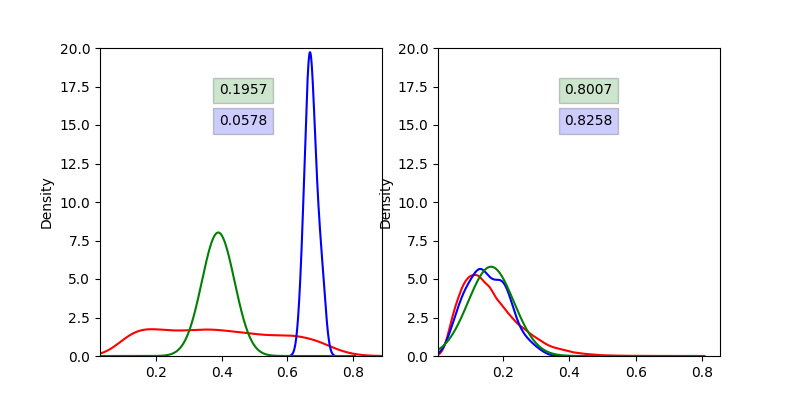

MovieWriter ffmpeg unavailable; using Pillow instead.


In [83]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from scipy.stats import norm

info = infoMBB

# create the figure and axes objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4)) ##If comparing, use 2 figures, uncomment this line and change plotSecond to True
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4)) ##If single image, uncomment this line and change plotSecond to False

# function that draws each frame of the animation
def animate(i, ch='PZ', duration=60, feature='alpha', info=info, ylim=20, plotRMC=True,
            global_color='red', average_color='green', subject_color='blue', plotSecond=True,
           ch2=None, duration2=2, feature2='theta'):
    
    
    
    if plotSecond:
        plot(ax[0], i, ch, duration, feature, info, ylim, plotRMC, global_color, average_color, subject_color)
        
        #If any of the parameters for the second plot was not passed, use the same value as the ones used in the fisrt plot
        ch2 = ch2 if ch2 is not None else ch
        duration2 = duration2 if duration2 is not None else duration
        feature2 = feature2 if feature2 is not None else feature
            
        #plotting
        plot(ax[1], i, ch2, duration2, feature2, info, ylim, plotRMC, global_color, average_color, subject_color)
    else:
        plot(ax, i, ch, duration, feature, info, ylim, plotRMC, global_color, average_color, subject_color)
    
ani = FuncAnimation(fig, animate, frames=np.arange(0,len(info.subjectList),1), interval=1000, repeat=False, blit=True)

ani.save(outdir+'best_worse.gif') #to save in gif format, useful for .pptx

plt.show()

Interesting plot to demonstrate a case where the choice of epoch duration can be aided by RMV:
-Plot PZ, beta, at 2s (in bottom 20 RMV) and 60s(in top 10 RMV)
Also:
-Plot PZ, 60s, alpha versus PZ, 2s, theta (top1 vs bottom1)

## Answering the Research Questions

In [84]:
## Specific Objective 3: Order features (including configurations) by their mean RMC
## For MBB
import pandas as pd

featureNames = combinedFeatures

mRMC_MBB = pd.Series(infoMBB.meanRMC, index=featureNames)
#orderedFeaturesMBB = mRMC_MBB.sort_values(ascending=True).index

## For DR
import pandas as pd
mRMC_DR = pd.Series(infoDR.meanRMC, index=featureNames)

## For MODMA
import pandas as pd
mRMC_MODMA = pd.Series(infoMODMA.meanRMC, index=featureNames)

In [85]:
def statistic(x, y):
    return stats.spearmanr(x, y).correlation

#### RQ 1: By selecting features with little intra-subject variability, can we reduce the divergence in selected features among different datasets?
    – H0: The ranking of features (ordered by it’s RMC) from two different datasets will be uncorrelated;
    
    – H1: The ranking of features will be positively correlated between the two datasets.

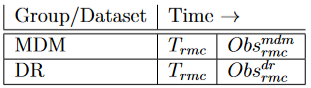

In [86]:
## Specific Objective 4: Evaluate the Correlation between the rankings of 2 datasets, correcting for randomness
## (for DR and MODMA)
## Notice that the first intervention is made as an correction; and the Design above is an illustration of this idea

from scipy import stats
res = stats.permutation_test((mRMC_DR, mRMC_MODMA), statistic, vectorized=False,
                       permutation_type='pairings',  ##this permutation allows to break the parings, being suitable for spearman
                       alternative='two-sided')
print('corr='+str(np.round(res.statistic,4)),' p-value='+str(res.pvalue))


D:\WorkspaceDoc\Python\venv\Lib\site-packages\scipy\stats\_resampling.py:840: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


corr=0.7384  p-value=0.0002


#### RQ 2: Given a set of features that have sufficiently small intra-subject variability, can these features achieve similar values in different datasets?

    – H0: Considering a feature ranking obtained from an independent database using RMV, the ranking of the mean differences of features across two different datasets, and the RMV value will be uncorrelated;
            
    - H1: Considering a feature ranking obtained from an independent database using RMV, the ranking of the mean differences of features across two different datasets, and the RMV value will be correlated;

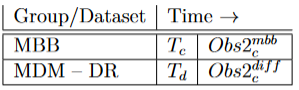

In [87]:
#Standardize (z-score) the features, them calcualtes the difference in means between datasets
def calculateMeanDifferences(infoA, infoB, featureKeys):
    import pandas as pd
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    #from tqdm import tqdm

    #Extracting and standardizing feature-values
    dataA = dict()
    dataB = dict()
    diff = dict()
    for key in featureKeys:
        # for infoA
        flat = []
        for subjData in infoA.data[key]:
            for data in subjData:
                flat.append(data)
        dataA[key] = scaler.fit_transform(np.array(flat).reshape(-1,1))

        #for infoB
        flat = []
        for subjData in infoB.data[key]:
            for data in subjData:
                flat.append(data)
        dataB[key] = scaler.fit_transform(np.array(flat).reshape(-1,1))

        #Calculating difference of means
        diff[key] = dataA[key].mean() - dataB[key].mean()
    
    return diff

In [88]:
diffDR_MDM = calculateMeanDifferences(infoDR, infoMODMA, combinedFeatures)
diffDR_MDM = pd.Series(diffDR_MDM, index=combinedFeatures)
mRMC_MBB = pd.Series(infoMBB.meanRMC, index=featureNames)

res2 = stats.permutation_test((mRMC_MBB, diffDR_MDM), statistic, vectorized=False,
                       permutation_type='pairings',  ##this permutation allows to break the parings, being suitable for spearman
                       alternative='two-sided')
print('corr='+str(np.round(res2.statistic,4)),' p-value='+str(res2.pvalue))

D:\WorkspaceDoc\Python\venv\Lib\site-packages\scipy\stats\_resampling.py:840: RuntimeWarning: overflow encountered in double_scalars
  n_max = factorial(n_obs_sample)**n_samples


corr=0.1656  p-value=0.043
